# Montar carpeta de drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Clasificador de imágenes

In [2]:
# Importación de las librerías necesarias
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import sys

# Configuración de la visualización para matplotlib
%matplotlib inline

# Configuración de parámetros

In [3]:
# Configuración de las dimensiones de la imagen y parámetros
width_shape = 224
height_shape = 224
num_classes = 24
epochs = 100
batch_size = 32
image_shape = (224, 224, 3)

# Path de dataset

In [4]:
# Directorios para los datos de entrenamiento y validación
train_data_dir = r'C:\Users\johns\Desktop\TFG\NA\train'
validation_data_dir = r'C:\Users\johns\Desktop\TFG\NA\valid'

# Generador de imágenes

In [5]:
# Generadores de datos con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Configuración del generador de datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

# Configuración del generador de datos de validación
validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical'
)

# Obtener el número de muestras de entrenamiento y validación
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

Found 3860 images belonging to 24 classes.
Found 120 images belonging to 24 classes.


# Entrenamiento de modelo VGG16

In [6]:
# Cargar el modelo preentrenado VGG16 sin la capa superior
image_input = Input(shape=(width_shape, height_shape, 3))
base_model = VGG16(input_tensor=image_input, include_top=False, weights='imagenet')

# Congelar las capas del modelo original de VGG16
for layer in base_model.layers:
    layer.trainable = False
# Descongelar la última capa convolucional de VGG16
base_model.layers[-2].trainable = True


# Añadirmos una capa con la cantidad de clases que tenemos
x = GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5, name="top_dropout")(x)
outputs = Dense(num_classes, activation="softmax", name="pred")(x)

# Crear el modelo final
custom_vgg_model = Model(inputs=base_model.input, outputs=outputs)

# Compilar el modelo con Adam
custom_vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

custom_vgg_model.summary()

# Definir ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo con ModelCheckpoint
model_history = custom_vgg_model.fit(
    train_generator,
    steps_per_epoch=math.ceil(nb_train_samples / batch_size),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=math.ceil(nb_validation_samples / batch_size),
    callbacks=[checkpoint, reduce_lr, early_stopping],
    verbose=1
)

# Guardar el modelo
custom_vgg_model.save('custom_vgg_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Gráficas de entrenamiento y validación (accuracy - loss)

In [7]:
# Función para graficar la pérdida y precisión del entrenamiento
def plotTraining(hist, epochs, typeData):

    if typeData == "loss":
        plt.figure(1, figsize=(10, 5))
        yc = hist.history['loss']
        xc = range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc, yc, '-r', label='Loss Training')
    if typeData == "accuracy":
        plt.figure(2, figsize=(10, 5))
        yc = hist.history['accuracy']
        for i in range(len(yc)):
            yc[i] = 100 * yc[i]
        xc = range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc, yc, '-r', label='Accuracy Training')
    if typeData == "val_loss":
        plt.figure(1, figsize=(10, 5))
        yc = hist.history['val_loss']
        xc = range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc, yc, '-b', label='Loss Validate')
    if typeData == "val_accuracy":
        plt.figure(2, figsize=(10, 5))
        yc = hist.history['val_accuracy']
        for i in range(len(yc)):
            yc[i] = 100 * yc[i]
        xc = range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc, yc, '-b', label='Training Validate')

    plt.rc('xtick', labelsize=24)
    plt.rc('ytick', labelsize=24)
    plt.rc('legend', fontsize=18)
    plt.legend()
    plt.xlabel('Number of Epochs', fontsize=24)
    plt.grid(True)

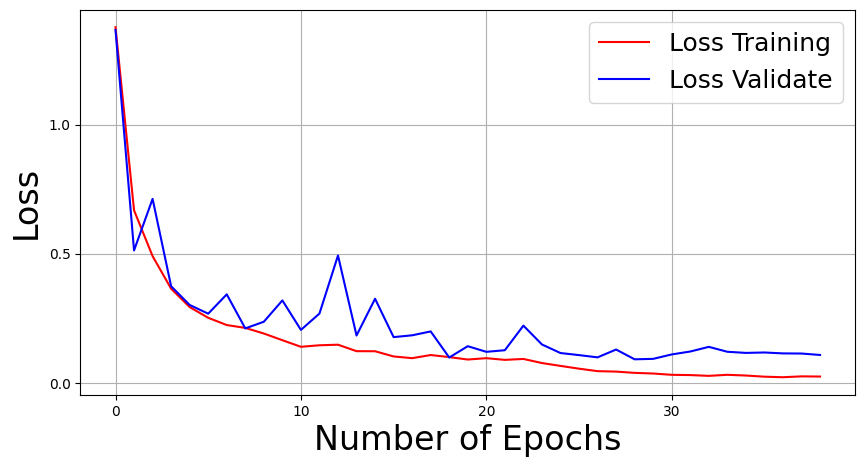

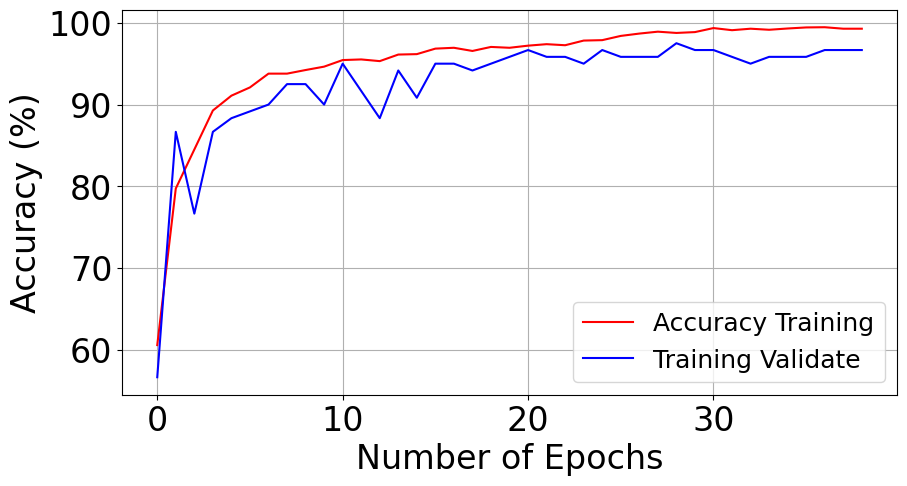

In [8]:
# Obtener el número de épocas completadas
num_epochs_done = len(model_history.history['loss'])

# Graficar la pérdida y precisión del entrenamiento
plotTraining(model_history, num_epochs_done, "loss")
plotTraining(model_history, num_epochs_done, "accuracy")
plotTraining(model_history, num_epochs_done, "val_loss")
plotTraining(model_history, num_epochs_done, "val_accuracy")

# Matriz de confusión y métricas de desempeño

Found 121 images belonging to 24 classes.


C:\Users\johns\AppData\Local\Temp\ipykernel_14056\339527252.py:43: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))
C:\Users\johns\anaconda3\envs\prueba\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\johns\anaconda3\envs\prueba\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\johns\anaconda3\envs\prueba

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           1     0.0000    0.0000    0.0000         5
           2     1.0000    1.0000    1.0000         5
           3     0.7143    1.0000    0.8333         5
           4     0.8333    1.0000    0.9091         5
           5     0.6667    0.4000    0.5000         5
           6     0.4167    1.0000    0.5882         5
           7     0.8333    1.0000    0.9091         5
           8     0.8000    0.8000    0.8000         5
           9     0.8333    1.0000    0.9091         5
          10     1.0000    0.4000    0.5714         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    1.0000    1.0000         5
          13     1.0000    0.4000    0.5714         5
          14     1.0000    1.0000    1.0000         5
          15     1.0000    0.4000    0.5714         5
          16     1.0000    0.6000    0.7500         5
          17     0.7500    

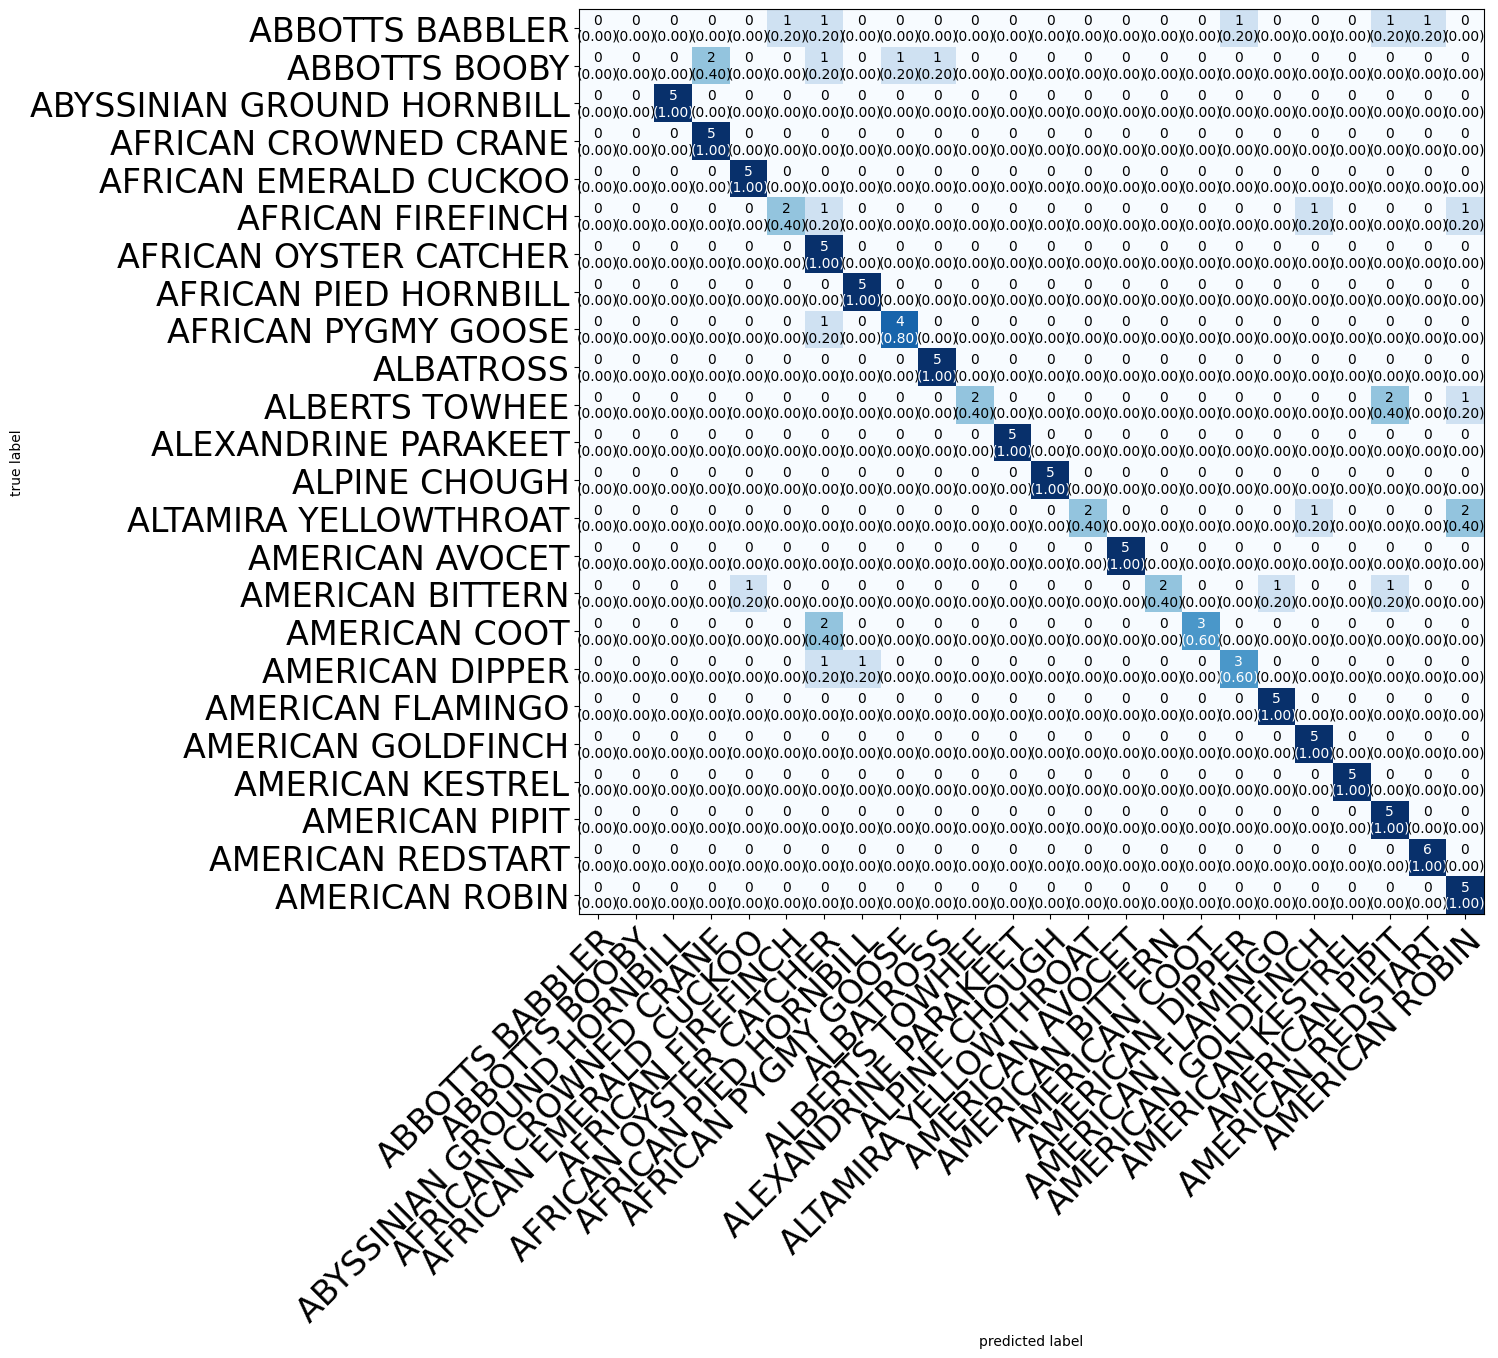

In [12]:
names = ['ABBOTTS BABBLER',
          'ABBOTTS BOOBY',
          'ABYSSINIAN GROUND HORNBILL',
          'AFRICAN CROWNED CRANE',
          'AFRICAN EMERALD CUCKOO',
          'AFRICAN FIREFINCH',
          'AFRICAN OYSTER CATCHER',
          'AFRICAN PIED HORNBILL',
          'AFRICAN PYGMY GOOSE',
          'ALBATROSS',
          'ALBERTS TOWHEE',
          'ALEXANDRINE PARAKEET',
          'ALPINE CHOUGH',
          'ALTAMIRA YELLOWTHROAT',
          'AMERICAN AVOCET',
          'AMERICAN BITTERN',
          'AMERICAN COOT',
          'AMERICAN DIPPER',
          'AMERICAN FLAMINGO',
          'AMERICAN GOLDFINCH',
          'AMERICAN KESTREL',
          'AMERICAN PIPIT',
          'AMERICAN REDSTART',
          'AMERICAN ROBIN']

# Configuración del generador de datos de prueba
test_data_dir = r'C:\Users\johns\Desktop\TFG\NA\test'
test_datagen = ImageDataGenerator(1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Cargar el modelo guardado
custom_Model = load_model("custom_vgg_model.h5")

# Realizar predicciones con el modelo
predictions = custom_Model.predict_generator(generator=test_generator, steps=len(test_generator))

# Obtener las clases predichas y reales
y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

# Matriz de confusión
matc = confusion_matrix(y_real, y_pred)

# Mostrar la matriz de confusión
plot_confusion_matrix(conf_mat=matc, figsize=(15, 15), class_names=names, show_normed=True)
plt.tight_layout()

# Imprimir el reporte de clasificación
print(classification_report(y_real, y_pred, digits=4))

In [13]:
print(y_real)

[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9
  9  9 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14
 14 14 14 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 22 23 23 23 23
 23]


In [14]:
print(y_pred)

[ 5 17 22 21  6  3  8  6  9  3  2  2  2  2  2  3  3  3  3  3  4  4  4  4
  4 23 19  5  6  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  6  9  9  9
  9  9 21 23 10 10 21 11 11 11 11 11 12 12 12 12 12 13 13 19 23 23 14 14
 14 14 14 15 18 15 21  4 16  6  6 16 16  6 17  7 17 17 18 18 18 18 18 19
 19 19 19 19 20 20 20 20 20 21 21 21 21 21 22 22 22 22 22 22 23 23 23 23
 23]
